In [1]:
import subprocess
import sys
GITPATH = subprocess.run('git rev-parse --show-toplevel'.split(' '), \
        stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n','')
sys.path.append(GITPATH)
import dobroEnv

/home/hogun/anaconda2/envs/gym/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

In [3]:
gym.logger.set_level(40)

In [4]:
ENV_NAME = 'DobroHalfCheetah-v0'
input_dim = 20
action_dim = 6

In [5]:
NUM_THREADS = 8

#T_max = 10000
MAX_EP = 200000
t_max = 100
print_freq = 500

beta = 0.001   # entropy regularization
gamma = 0.99
#alpha = 0.99   # RMSProb decay factor
learning_rate = 1e-4
decay_rate = 0.999

class A3C(nn.Module):
    def __init__(self, input_dim, action_dim, max_ep=0, is_global=False):
        super(A3C, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.max_ep = max_ep
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, action_dim)
        self.fc_sigma = nn.Linear(64, action_dim)
        self.fc_value = nn.Linear(64, 1)
        
        self.ep_counter = None
        self.ep_returns = None
        self.average_returns = None
        
        if is_global:
            self.set_global()
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        action_mu = self.fc_mu(x)
        action_sigma = self.fc_sigma(x)
        V = self.fc_value(x)
        return action_mu, action_sigma, V
    
    def set_global(self):
        self.ep_counter = mp.Value('i')
        self.ep_counter.value = 0
        self.ep_returns = mp.Array('d', self.max_ep)
        self.average_returns = mp.Array('d',self.max_ep)
        
    def log_episode(self, ep_return):
        c = self.ep_counter.value
        self.ep_returns[c] = ep_return
        self.average_returns[c] = np.mean(self.ep_returns[max(0, c-99):c+1])
        self.ep_counter.value += 1
        return self.ep_counter.value

In [6]:
class A3C_v3(nn.Module):
    def __init__(self, input_dim, action_dim, max_ep=0, is_global=False):
        super(A3C_v3, self).__init__()
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.max_ep = max_ep
        
        self.fc_pi1 = nn.Linear(input_dim, 64)
        self.fc_pi2 = nn.Linear(64, 64)
        self.fc_mu = nn.Linear(64, action_dim)
        self.fc_sigma = nn.Linear(64, action_dim)
        self.fc_v1 = nn.Linear(input_dim, 64)
        self.fc_v2 = nn.Linear(64, 64)
        self.fc_v3 = nn.Linear(64, 1)
        
        self.ep_counter = None
        self.ep_returns = None
        self.average_returns = None
        
        if is_global:
            self.set_global()
    
    def forward(self, x):
        x_pi = F.relu(self.fc_pi1(x))
        x_pi = F.relu(self.fc_pi2(x_pi))
        action_mu = self.fc_mu(x_pi)
        action_sigma = self.fc_sigma(x_pi)
        
        x_v = F.relu(self.fc_v1(x))
        x_v = F.relu(self.fc_v2(x_v))
        V = self.fc_v3(x_v)
        return action_mu, action_sigma, V
    
    def set_global(self):
        self.ep_counter = mp.Value('i')
        self.ep_counter.value = 0
        self.ep_returns = mp.Array('d', self.max_ep)
        self.average_returns = mp.Array('d',self.max_ep)
        
    def log_episode(self, ep_return):
        c = self.ep_counter.value
        self.ep_returns[c] = ep_return
        self.average_returns[c] = np.mean(self.ep_returns[max(0, c-99):c+1])
        self.ep_counter.value += 1
        return self.ep_counter.value

In [7]:
def train(lock, globalNet, optimizer, scheduler, tmax, pid):
    t = 0
    done = False
    ep_return = 0
    log_episode_return = []
    cur_ep = 0
    step_count = 0
    
    localNet = A3C_v3(input_dim, action_dim)
    localNet.load_state_dict(globalNet.state_dict())
    env = gym.make(ENV_NAME)
    env.unwrapped.initialize()
    obs = env.reset()
    
    while globalNet.ep_counter.value < MAX_EP:
        t_start = t
        buff_value = []
        buff_reward = []
        buff_logp = []
        buff_entropy = []

        while t_start-t < t_max:
            mu, sigma, V = localNet(torch.tensor(obs.astype(np.float32)))
            Softplus=nn.Softplus()     
            sigma = Softplus(sigma + 1e-5) # constrain to sensible values
            normal_dist = torch.normal(mu, sigma)
            
            sigma = Softplus(sigma + 1e-5) # constrain to sensible values
            action_dist = torch.normal(mu, sigma)
            action = action_dist.detach().numpy()
            action = action.clip(env.action_space.low, env.action_space.high)
            
            entropy = -0.5 * (torch.log(2. * np.pi * sigma) + 1.)
            
            # log prob: gaussian negative log-likelihood
            log_prob = torch.log(1/torch.sqrt(2*np.pi*sigma**2)) - (action_dist-mu)**2/(2*sigma**2)

            obs, reward, done, _ = env.step(action)
            step_count += 1
            ep_return += reward

            buff_value.append(V)
            buff_reward.append(reward)
            buff_logp.append(log_prob.sum())
            buff_entropy.append(entropy)
            t += 1
            
            if done:
                cur_ep = globalNet.log_episode(ep_return)
                obs = env.reset()
                if step_count==env._max_episode_steps:
                    done = False
                step_count = 0
                ep_return = 0
                break

        R = V if not done else 0
        policy_loss = 0
        value_loss = 0
        entropy_loss = 0
        for i in range(-1, -(t-t_start)-1, -1):
            R = buff_reward[i] + gamma*R
            TD = R - buff_value[i]
            policy_loss += buff_logp[i] * TD.detach()
            value_loss += torch.pow(TD, 2)
            entropy_loss += buff_entropy[i].sum()
        loss = - policy_loss + value_loss - beta*entropy_loss
        
        lock.acquire()
        try:
            optimizer.zero_grad()
            loss.backward()
            for local_param, global_param in zip(localNet.parameters(), globalNet.parameters()):
                global_param.grad = local_param.grad
            optimizer.step()
        finally:
            lock.release()
        localNet.load_state_dict(globalNet.state_dict())
        
        if cur_ep%print_freq==0:
            print('[%d] Process'%pid)
            print('%d/%d episodes. (%.2f%%)'%(cur_ep, MAX_EP, cur_ep/MAX_EP*100))
            #print('Current learning rate:', optimizer.param_groups[0]['lr'])
            print('Total loss:\t', loss.data.numpy()[0])
            print('Entropy\t\tPolicy\t\tValue')
            print('%.2f\t\t%.2f\t\t%.2f'%(entropy_loss.data.numpy(), policy_loss.data.numpy()[0], \
                  value_loss.data.numpy()[0]))
            print('Epside Return: [%.1f]'%globalNet.average_returns[globalNet.ep_counter.value-1])
            print()
            
            global log_df, fig_num
            plt.figure(figsize=(10, 5))
            average_returns = np.array(globalNet.average_returns[:])
            ep_returns = np.array(globalNet.ep_returns[:])
            nonzero_indices = average_returns!=0.0
            plt.plot(ep_returns[nonzero_indices], color='lightgreen')
            plt.plot(average_returns[nonzero_indices], color='green')
            plt.savefig('A3C_v3_HalfCheetah_%d.png'%fignum)
            plt.close()
            
            raw_data = [cur_ep/MAX_EP*100, cur_ep, loss.data.numpy()[0], globalNet.average_returns[globalNet.ep_counter.value-1], optimizer.param_groups[0]['lr']]
            log_df = log_df.append(pd.Series(raw_data, index = log_df.columns), ignore_index=True)
        
        scheduler.step()

In [8]:
globalNet = A3C_v3(input_dim, action_dim, MAX_EP, is_global=True)
globalNet.share_memory()

optimizer = optim.Adam(globalNet.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
lock = mp.Lock()

Softplus=nn.Softplus()
log_df = pd.DataFrame(columns=['running', 'EP', 'Loss', 'Return', 'LR'])
fignum = len([f for f in os.listdir() if 'v3_HalfCheetah' in f and 'png' in f])

processes = []
for p_idx in range(NUM_THREADS):
    p = mp.Process(target=train, args=(lock, globalNet, optimizer, scheduler, t_max, p_idx))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

[0] Process
500/200000 episodes. (0.25%)
Total loss:	 92473.336
Entropy		Policy		Value
-8775.47		-37027.23		55437.33
Epside Return: [64.0]

[4] Process
1000/200000 episodes. (0.50%)
Total loss:	 68970.016
Entropy		Policy		Value
-8786.23		5510.85		74472.08
Epside Return: [137.4]

[3] Process
1500/200000 episodes. (0.75%)
Total loss:	 19642.85
Entropy		Policy		Value
-8790.06		48368.00		68002.05
Epside Return: [158.8]

[0] Process
2000/200000 episodes. (1.00%)
Total loss:	 412270.12
Entropy		Policy		Value
-8781.94		-117430.62		294830.72
Epside Return: [220.6]

[4] Process
2500/200000 episodes. (1.25%)
Total loss:	 189030.86
Entropy		Policy		Value
-8548.05		-17637.66		171384.66
Epside Return: [594.0]

[1] Process
3000/200000 episodes. (1.50%)
Total loss:	 412215.22
Entropy		Policy		Value
-8511.87		-77410.51		334796.22
Epside Return: [769.7]

[6] Process
3500/200000 episodes. (1.75%)
Total loss:	 799505.5
Entropy		Policy		Value
-7746.80		61239.45		860737.19
Epside Return: [791.3]

[0] Proce


[7] Process
29000/200000 episodes. (14.50%)
Total loss:	 143510.64
Entropy		Policy		Value
-8077.17		-26663.57		116838.98
Epside Return: [1261.0]

[0] Process
29500/200000 episodes. (14.75%)
Total loss:	 291415.56
Entropy		Policy		Value
-8086.48		47980.80		339388.28
Epside Return: [1345.9]

[4] Process
30000/200000 episodes. (15.00%)
Total loss:	 1064508.4
Entropy		Policy		Value
-2673.98		122992.38		1187498.12
Epside Return: [1318.8]

[7] Process
30500/200000 episodes. (15.25%)
Total loss:	 397839.0
Entropy		Policy		Value
-8088.38		-74667.23		323163.69
Epside Return: [1287.3]

[4] Process
31000/200000 episodes. (15.50%)
Total loss:	 291513.22
Entropy		Policy		Value
-8085.68		4986.26		296491.38
Epside Return: [1310.9]

[5] Process
31500/200000 episodes. (15.75%)
Total loss:	 248526.7
Entropy		Policy		Value
-8073.35		-69470.65		179047.98
Epside Return: [1309.3]

[0] Process
32000/200000 episodes. (16.00%)
Total loss:	 1020455.8
Entropy		Policy		Value
-6581.21		45281.62		1065730.88
Epside

Entropy		Policy		Value
-5795.33		181111.86		1791189.88
Epside Return: [1255.2]

[7] Process
57500/200000 episodes. (28.75%)
Total loss:	 156067.03
Entropy		Policy		Value
-8063.02		2218.15		158277.12
Epside Return: [1272.8]

[1] Process
58000/200000 episodes. (29.00%)
Total loss:	 694475.94
Entropy		Policy		Value
-8083.09		78239.41		772707.31
Epside Return: [1218.4]

[6] Process
58500/200000 episodes. (29.25%)
Total loss:	 559278.5
Entropy		Policy		Value
-8060.35		45759.63		605030.06
Epside Return: [1323.6]

[1] Process
59000/200000 episodes. (29.50%)
Total loss:	 227578.83
Entropy		Policy		Value
-8072.42		-34734.12		192836.62
Epside Return: [1305.2]

[7] Process
59500/200000 episodes. (29.75%)
Total loss:	 176547.6
Entropy		Policy		Value
-8065.38		18357.09		194896.62
Epside Return: [1276.0]

[2] Process
60000/200000 episodes. (30.00%)
Total loss:	 1062771.8
Entropy		Policy		Value
-2283.42		122272.83		1185042.38
Epside Return: [1290.0]

[6] Process
60500/200000 episodes. (30.25%)
Total 


[6] Process
85500/200000 episodes. (42.75%)
Total loss:	 337943.06
Entropy		Policy		Value
-8070.85		-3981.69		333953.31
Epside Return: [1296.6]

[5] Process
86000/200000 episodes. (43.00%)
Total loss:	 219795.33
Entropy		Policy		Value
-8069.29		-38293.56		181493.70
Epside Return: [1264.1]

[3] Process
86500/200000 episodes. (43.25%)
Total loss:	 340498.47
Entropy		Policy		Value
-8076.70		-11047.36		329443.03
Epside Return: [1293.9]

[5] Process
87000/200000 episodes. (43.50%)
Total loss:	 529364.5
Entropy		Policy		Value
-8094.54		51638.19		580994.56
Epside Return: [1348.3]

[6] Process
87500/200000 episodes. (43.75%)
Total loss:	 238988.97
Entropy		Policy		Value
-8056.86		-29419.83		209561.08
Epside Return: [1315.8]

[0] Process
88000/200000 episodes. (44.00%)
Total loss:	 341641.9
Entropy		Policy		Value
-8075.50		50995.25		392629.09
Epside Return: [1319.9]

[3] Process
88500/200000 episodes. (44.25%)
Total loss:	 256045.4
Entropy		Policy		Value
-8056.20		-60140.82		195896.53
Epside R

Total loss:	 247411.22
Entropy		Policy		Value
-8079.62		-3757.47		243645.67
Epside Return: [1353.9]

[2] Process
114000/200000 episodes. (57.00%)
Total loss:	 852056.4
Entropy		Policy		Value
-805.37		71918.89		923974.44
Epside Return: [1275.1]

[2] Process
114500/200000 episodes. (57.25%)
Total loss:	 163987.23
Entropy		Policy		Value
-8065.66		-30453.51		133525.66
Epside Return: [1297.0]

[3] Process
115000/200000 episodes. (57.50%)
Total loss:	 706294.44
Entropy		Policy		Value
-737.82		60840.10		767133.81
Epside Return: [1320.1]

[6] Process
115500/200000 episodes. (57.75%)
Total loss:	 308937.5
Entropy		Policy		Value
-8060.72		-70313.13		238616.30
Epside Return: [1306.5]

[6] Process
116000/200000 episodes. (58.00%)
Total loss:	 342335.66
Entropy		Policy		Value
-8090.91		-4570.34		337757.22
Epside Return: [1284.0]

[2] Process
116500/200000 episodes. (58.25%)
Total loss:	 183508.83
Entropy		Policy		Value
-8060.28		-25978.71		157522.06
Epside Return: [1315.8]

[6] Process
117000/20000

Total loss:	 298218.88
Entropy		Policy		Value
-8056.79		-63498.20		234712.61
Epside Return: [1285.1]

[6] Process
142000/200000 episodes. (71.00%)
Total loss:	 276969.38
Entropy		Policy		Value
-8068.38		-21058.73		255902.58
Epside Return: [1337.9]

[4] Process
142500/200000 episodes. (71.25%)
Total loss:	 335321.7
Entropy		Policy		Value
-8051.55		-46910.88		288402.75
Epside Return: [1324.4]

[0] Process
143000/200000 episodes. (71.50%)
Total loss:	 365733.3
Entropy		Policy		Value
-8073.37		-19621.00		346104.25
Epside Return: [1269.5]

[4] Process
143500/200000 episodes. (71.75%)
Total loss:	 1174646.6
Entropy		Policy		Value
-6559.59		84721.16		1259361.25
Epside Return: [1301.8]

[5] Process
144000/200000 episodes. (72.00%)
Total loss:	 263255.12
Entropy		Policy		Value
-8074.43		-22657.00		240590.06
Epside Return: [1301.0]

[4] Process
144500/200000 episodes. (72.25%)
Total loss:	 287980.7
Entropy		Policy		Value
-8062.54		-48583.32		239389.30
Epside Return: [1286.6]

[0] Process
145000/

Total loss:	 783214.8
Entropy		Policy		Value
-711.10		67209.48		850423.62
Epside Return: [1258.3]

[5] Process
170000/200000 episodes. (85.00%)
Total loss:	 206239.33
Entropy		Policy		Value
-8066.89		-29557.56		176673.70
Epside Return: [1357.2]

[0] Process
170500/200000 episodes. (85.25%)
Total loss:	 266714.44
Entropy		Policy		Value
-8079.75		8238.69		274945.03
Epside Return: [1319.9]

[5] Process
171000/200000 episodes. (85.50%)
Total loss:	 110468.266
Entropy		Policy		Value
-8069.32		4905.04		115365.23
Epside Return: [1317.0]

[7] Process
171500/200000 episodes. (85.75%)
Total loss:	 194324.44
Entropy		Policy		Value
-8060.57		11584.93		205901.30
Epside Return: [1288.4]

[3] Process
172000/200000 episodes. (86.00%)
Total loss:	 209679.69
Entropy		Policy		Value
-8078.80		23091.38		232762.98
Epside Return: [1307.6]

[4] Process
172500/200000 episodes. (86.25%)
Total loss:	 252138.22
Entropy		Policy		Value
-8072.59		33914.48		286044.62
Epside Return: [1255.5]

[0] Process
173000/200000

Entropy		Policy		Value
-8073.62		38319.01		379843.16
Epside Return: [1318.0]

[4] Process
198000/200000 episodes. (99.00%)
Total loss:	 265838.4
Entropy		Policy		Value
-8064.72		-18857.41		246972.92
Epside Return: [1294.7]

[0] Process
198500/200000 episodes. (99.25%)
Total loss:	 320274.53
Entropy		Policy		Value
-8068.52		-11282.57		308983.91
Epside Return: [1279.5]

[3] Process
199000/200000 episodes. (99.50%)
Total loss:	 308991.28
Entropy		Policy		Value
-8097.86		92049.80		401033.00
Epside Return: [1242.6]

[7] Process
199500/200000 episodes. (99.75%)
Total loss:	 366726.66
Entropy		Policy		Value
-8070.71		39789.24		406507.84
Epside Return: [1292.9]



Process Process-7:
Traceback (most recent call last):
  File "/home/hogun/anaconda2/envs/gym/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hogun/anaconda2/envs/gym/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
IndexError: invalid index
  File "<ipython-input-7-b409b9399f04>", line 49, in train
    cur_ep = globalNet.log_episode(ep_return)
  File "<ipython-input-6-c29db70bbb99>", line 42, in log_episode
    self.ep_returns[c] = ep_return
  File "/home/hogun/anaconda2/envs/gym/lib/python3.6/multiprocessing/sharedctypes.py", line 226, in __setitem__
    self._obj[i] = value


[4] Process
200000/200000 episodes. (100.00%)
Total loss:	 228642.84
Entropy		Policy		Value
-8069.16		31237.00		259871.78
Epside Return: [1340.7]



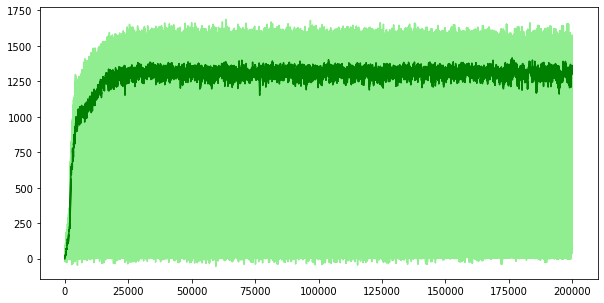

In [9]:
plt.figure(figsize=(10, 5))
average_returns = np.array(globalNet.average_returns[:])
ep_returns = np.array(globalNet.ep_returns[:])
nonzero_indices = average_returns!=0.0
plt.plot(ep_returns[nonzero_indices], color='lightgreen')
plt.plot(average_returns[nonzero_indices], color='green')
plt.show()
#fignum = len([f for f in os.listdir() if 'v3_HalfCheetah' in f and 'png' in f])
#plt.savefig('A3C_v3_HalfCheetah_%d.png'%fignum)

In [10]:
log_df.head()

,running,EP,Loss,Return,LR


env = gym.make(ENV_NAME)
env.unwrapped.initialize(is_render=True)
obs = env.reset()
ep_return = 0

while False: #True:
    mu, sigma, V = globalNet(torch.tensor(obs.astype(np.float32)))
    Softplus=nn.Softplus()     
    sigma = Softplus(sigma + 1e-5) # constrain to sensible values
    normal_dist = torch.normal(mu, sigma)

    sigma = Softplus(sigma + 1e-5) # constrain to sensible values
    action_dist = torch.normal(mu, sigma)
    action = action_dist.detach().numpy()
    action = action.clip(env.action_space.low, env.action_space.high)
    
    obs, reward, done, _ = env.step(action)
    ep_return += reward
    if done:
        env.reset()
        print('Score:', ep_return)
        ep_return = 0